# Log File einlesen

In [2]:
import re
import pandas as pd

with open("../berechnung.log", "r") as f:
    lines = f.readlines()
    
records_player = []
records_game = []

for line in lines:
    line = line.strip()
    
    m = re.search(
        r"Pitch Result bei step size (?P<step>\d+) für (?P<game_id>\w+) in (?P<time>[\d.]+) Sekunden",
        line
    )
    if m:
        records_game.append({
            "type": "game",
            "step": int(m["step"]),
            "game_id": m["game_id"],
            "time_sec": float(m["time"]),
        })
        continue
    
    m = re.search(
        r"Frames erstellen für (?P<player>\w+) mit (?P<frames>\d+) Frames bei step size (?P<step>\d+) für (?P<game_id>\w+) mit (?P<method>\w+) in (?P<time>[\d.]+) Sekunden",
        line
    )
    if m:
        records_player.append({
            "type": "frames",
            "player": m["player"],
            "frames": int(m["frames"]),
            "step": int(m["step"]),
            "game_id": m["game_id"],
            "method": m["method"],
            "time_sec": float(m["time"]),
            "param_max_radius": None,
            "param_opt_step_size": None,
            "param_min_dist": None,
            "param_n": None
        })
        continue
    
    m = re.search(
        r"Pitch Result berechnen für (?P<player>\w+) mit (?P<frames>\d+) Frames für (?P<game_id>\w+) in (?P<time>[\d.]+) Sekunden",
        line
    )
    if m:
        records_player.append({
            "type": "pitch_result",
            "player": m["player"],
            "frames": int(m["frames"]),
            "step": None,    # kommt von "Frames erstellen"
            "game_id": m["game_id"],
            "method": None,
            "time_sec": float(m["time"]),
            "param_max_radius": None,
            "param_opt_step_size": None,
            "param_min_dist": None,
            "param_n": None
        })
        continue

    m = re.search(r"Params des oben genannten Runs: (.*)", line)
    if m and records_player:
        params = eval(m.group(1))
        for key, value in params.items():
            records_player[-1][f"param_{key}"] = value
            records_player[-2][f"param_{key}"] = value
    
df_games = pd.DataFrame(records_game)
df_player = pd.DataFrame(records_player)
df_player = df_player[df_player["param_n"].notna()]

In [4]:
# Player DF mergen
df_frames = df_player[df_player["type"] == "frames"].copy()
df_pitch = df_player[df_player["type"] == "pitch_result"].copy()

keys = ["player", "game_id", "frames"]
df_frames["run_idx"] = df_frames.groupby(keys).cumcount()
df_pitch["run_idx"] = df_pitch.groupby(keys).cumcount()

wide = df_frames.merge(
    df_pitch[keys + ["run_idx", "time_sec"]],
    on=keys + ["run_idx"], how="left", suffixes=("_frame", "_pitch")
)
wide = wide.rename(columns={
    "time_sec_frame": "time_frames_sec",
    "time_sec_pitch":  "time_pitch_sec"
})
wide["total_time_sec"] = wide["time_frames_sec"].fillna(0) + wide["time_pitch_sec"].fillna(0)

cols = keys + ["step", "method", "time_frames_sec", "time_pitch_sec", "total_time_sec"] + [c for c in wide.columns if c.startswith("param_")]
wide = wide[cols]

wide.head()

,player,game_id,frames,step,method,time_frames_sec,time_pitch_sec,total_time_sec,param_max_radius,param_opt_step_size,param_min_dist,param_n
0,home_25,J03WQQ,1003,25.0,random,142.2450,2210.7310,2352.9760,5.0,1.0,2.0,20.0
1,home_25,J03WQQ,201,125.0,random,18.6694,292.3684,311.0378,5.0,1.0,2.0,20.0
2,home_25,J03WQQ,201,125.0,random,52.2024,939.6736,991.8760,5.0,1.0,2.0,50.0
3,home_25,J03WQQ,201,125.0,all_positions,82.7304,1629.9930,1712.7234,5.0,1.0,2.0,20.0
4,home_13,J03WQQ,31,125.0,random,2.8612,34.1022,36.9634,5.0,1.0,2.0,20.0


In [69]:
# Game DF auswerten
df_games.groupby("step")["time_sec"].mean()

step
25     116.56040
125     25.95496
Name: time_sec, dtype: float64

In [94]:
# Player DF auswerten
# df = wide[
#     (wide["player"] == "home_25") & (wide["game_id"] == "J03WQQ")
#     ].copy()
df = wide.copy()
df["method"] = df.apply(
    lambda row: f"{row['method']}_n{int(row['param_n'])}" if row["method"] == "random" else row["method"],
    axis=1
)
df["time_per_frame"] = df["total_time_sec"] / df["frames"]

summary = (df.groupby("method")
        .agg(runs=("total_time_sec", "count"),
             mean_total=("total_time_sec", "mean"),
             median_total=("total_time_sec", "median"),
             mean_tpf=("time_per_frame", "mean"),
             median_tpf=("time_per_frame", "median"),
             weighted_tpf=("total_time_sec", lambda x: x.sum()))
        )
summary["weighted_tpf"] = summary["weighted_tpf"] / df.groupby("method")["frames"].sum()
summary = summary.sort_values("median_tpf")
# display(summary)

by_step = (df.groupby(["step", "method"])
           .agg(runs=("total_time_sec", "count"),
                median_tpf=("time_per_frame", "median"))
           .reset_index()
           .sort_values(["step", "median_tpf"]))
# display(by_step)

per_player = (df.groupby(["player", "method"])
              .agg(median_tpf=("time_per_frame", "median"),
                   mean_tpf=("time_per_frame", "mean"))
              .reset_index()
            )
# display(per_player)
player_fair = (per_player.groupby("method")[["median_tpf", "mean_tpf"]]
               .median()
               .sort_values(by="median_tpf"))
# display(player_fair)


q_low, q_high = df["time_per_frame"].quantile([0.05, 0.95])
df_trim = df[(df["time_per_frame"].between(q_low, q_high))]

pivot_total = pd.pivot_table(
    df_trim,
    index=["step"],
    columns="method",
    values=["total_time_sec"],
    aggfunc="mean"
).round(3)
pivot_mean = pd.pivot_table(
    df_trim,
    index=["step"],
    columns="method",
    values=["time_per_frame"],
    aggfunc="mean"
).round(3)
display(pivot_total)
display(pivot_mean)

total_time_sec                                  
method  all_positions random_n100 random_n20 random_n50
step                                                   
25.0              NaN         NaN   2352.976        NaN
125.0        1059.748    1008.223    173.086    401.254

time_per_frame                                  
method  all_positions random_n100 random_n20 random_n50
step                                                   
25.0              NaN         NaN      2.346        NaN
125.0           7.041        7.28      1.367      3.494

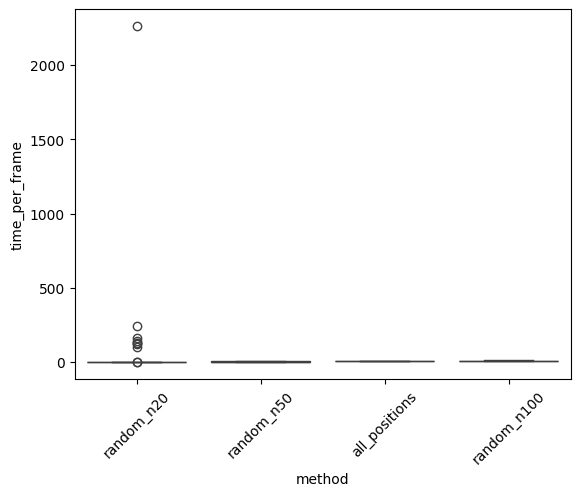

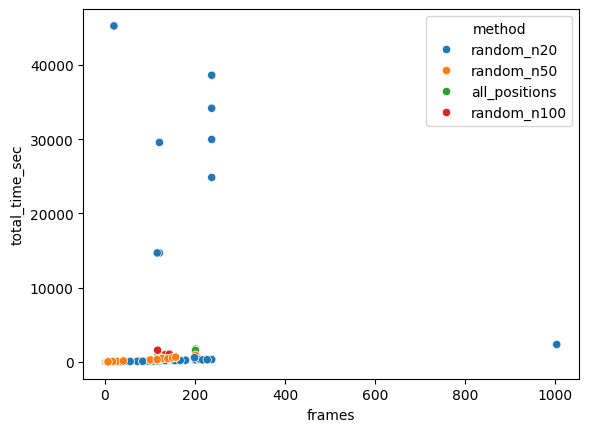

In [92]:
import seaborn as sns, matplotlib.pyplot as plt
sns.boxplot(data=df, x="method", y="time_per_frame"); plt.xticks(rotation=45); plt.show()
sns.scatterplot(data=df, x="frames", y="total_time_sec", hue="method"); plt.show()
